## Скачиваем данные

Получаем на Kaggle токен (файл kaggle.json), устанавливаем kaggle в нужное окружение:

`pip install kaggle`

Затем пытаемся скачать данные:

In [1]:
! kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Traceback (most recent call last):
  File "C:\Users\koval\anaconda3\envs\data-science-class\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\koval\anaconda3\envs\data-science-class\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\koval\anaconda3\envs\data-science-class\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\koval\.kaggle. Or use the environment method.


Ошибка говорит о том, что библиотека не может найти файл kaggle.json в папке `C:\Users\<имя пользователя>\.kaggle`

Переносим файл в эту папку, пробуем еще раз

In [2]:
! kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis


  0%|          | 0.00/1.99M [00:00<?, ?B/s]
 50%|#####     | 1.00M/1.99M [00:02<00:02, 459kB/s]
100%|##########| 1.99M/1.99M [00:02<00:00, 793kB/s]
100%|##########| 1.99M/1.99M [00:02<00:00, 714kB/s]


Разархивируем данные в папку data

In [6]:
! tar -xf twitter-entity-sentiment-analysis.zip --directory data

## Прочитаем данные

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle

In [24]:
df = pd.read_csv('data/twitter_training.csv', header=None)
df.columns = ['tweet_id', 'entity', 'sentiment', 'content']
df.head()

,tweet_id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [25]:
df['sentiment'] = pd.Categorical(df['sentiment'])
df = df.dropna()

Text(0.5, 1.0, 'Гистограмма сбалансированности классов')

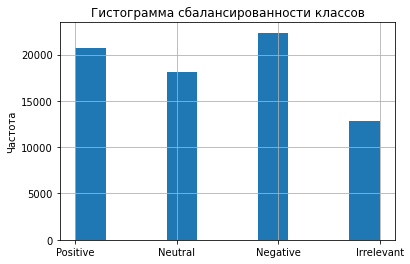

In [26]:
df['sentiment'].hist()
plt.ylabel('Частота')
plt.title('Гистограмма сбалансированности классов')

In [27]:
stemmer = PorterStemmer()

def remove_punctuation(sentence):
    return re.sub(r'[^\w\s]', '', sentence.lower())

def stem_sentence(sentence):
    words = sentence.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def preprocess_sentence(sentence):
    return stem_sentence(remove_punctuation(sentence))

preprocess_sentence('check, preprocessing, on, some, words,')

'check preprocess on some word'

In [28]:
df['processed_content'] = df['content'].apply(preprocess_sentence)

In [30]:
pipeline_lr = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", LogisticRegression()),
    ]
)
pipeline_rf = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", RandomForestClassifier()),
    ]
)

In [32]:
def fit_and_score_pipeline(df, pipeline):
    train, test = train_test_split(df)
    pipeline.fit(train['processed_content'], train['sentiment'])
    return pipeline.score(test['processed_content'], test['sentiment'])

In [33]:
fit_and_score_pipeline(df, pipeline_lr), fit_and_score_pipeline(df, pipeline_rf)

C:\Users\koval\anaconda3\envs\data-science-class\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.7531758473430996, 0.9074544569976756)

Случайный лес работает значительно лучше, сохраним этот пайплайн в файл и будем дальше использовать

In [36]:
def save_model(model, path):
    serialized_model = pickle.dumps(model)
    with open(path, 'wb+') as file:
        file.write(serialized_model)

def load_model(path):
    with open(path, 'rb') as file:
        content = file.read()
    return pickle.loads(content)

In [37]:
save_model(pipeline_rf, 'random_forest.pickle')

Если хотим получать предсказание, можем написать такую функцию

In [38]:
def predict(model, inp_string):
    model_input = preprocess_sentence(inp_string)
    return model.predict([model_input])

In [43]:
predict(pipeline_rf, 'I really appreciate this')

array(['Positive'], dtype=object)

Перенесем наши наработки в скрипты:

- `src/train.py` - обучает модель и сохраняет ее в файл
- `src/predict.py` - загружает модель из файла и предсказываем сентимент входных данных

In [46]:
!python -m src.train data/twitter_training.csv random_forest.pickle

On training data accuracy: 0.9095086220876805


In [44]:
!python -m src.predict random_forest.pickle "i appreciate this"

"i appreciate this" - Positive


In [45]:
!python -m src.predict random_forest.pickle "i hate this"

"i hate this" - Negative
